In [1]:
# Import the relevant modules

# Import the mathematical libraries
import math
import numpy as np
import pandas as pd

# Import the input output libraries
import os
import sys
import h5py

# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the machine learning libraries
from sklearn.model_selection import train_test_split
import pytorch_lightning as pL
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.transforms import v2
import torchsummary
torch.set_float32_matmul_precision('medium')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with h5py.File('Galaxy10_DECals.h5', 'r') as f:
    Galaxy10 = np.array(f['images'][:])
    labels = np.array(f['ans'][:])
Galaxy10.shape, labels.shape

((17736, 256, 256, 3), (17736,))

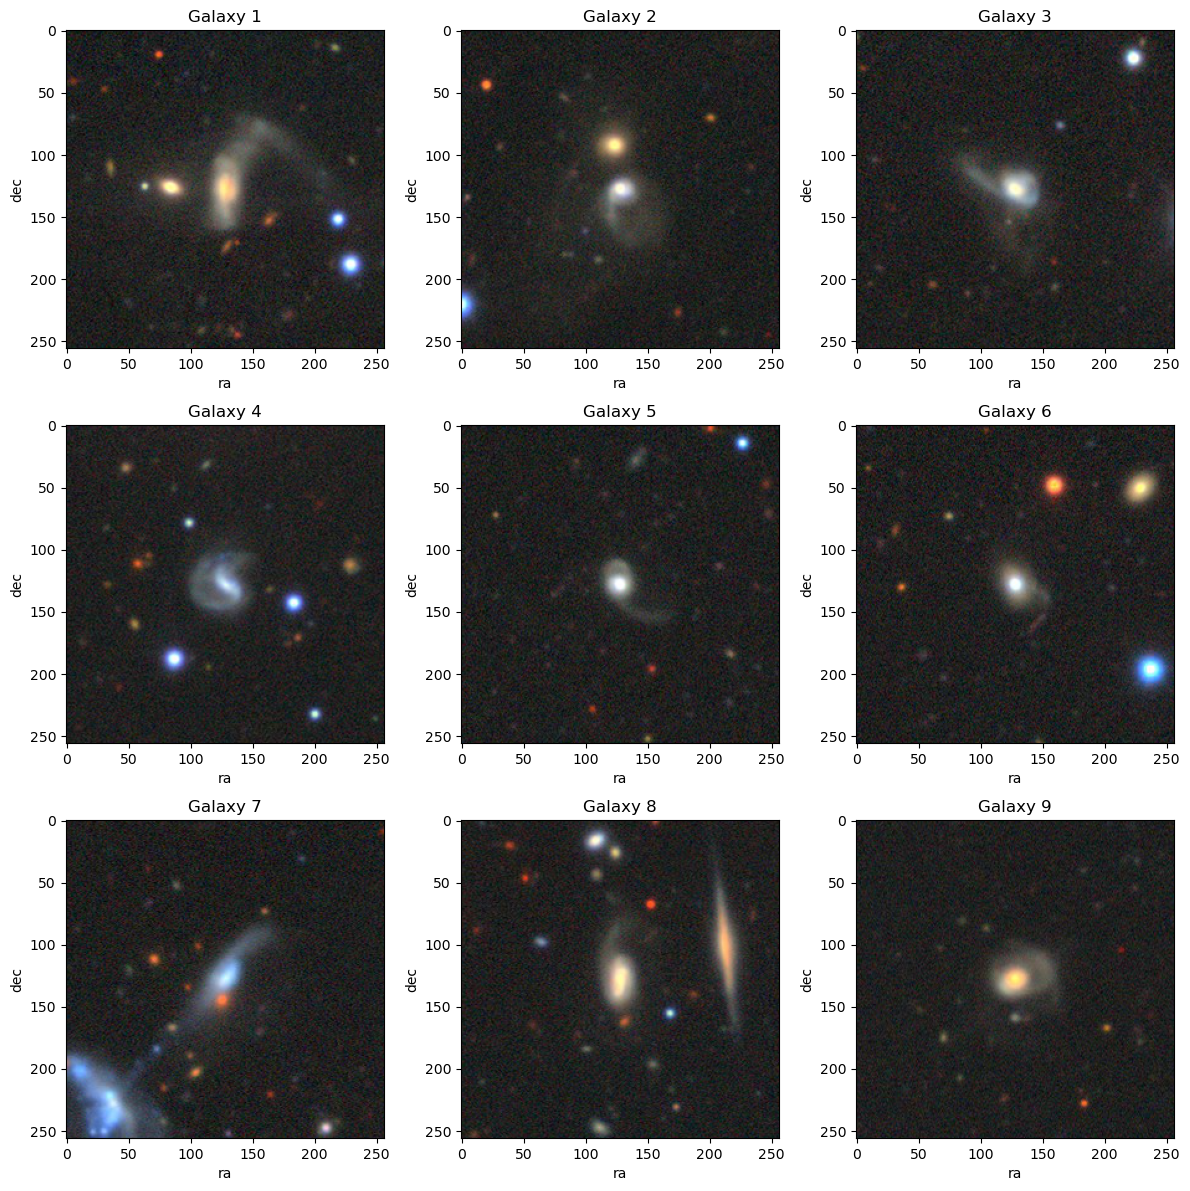

In [4]:
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Galaxy10[i])
    plt.title(f'Galaxy {i + 1}')
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.tight_layout()
plt.show()

In [7]:
Train_Validation_Images_Dataset, Test_Images_Dataset = Galaxy10[:int(len(Galaxy10) * 0.8)], Galaxy10[int(len(Galaxy10) * 0.8):]
Train_Validation_Labels_Dataset, Test_Labels_Dataset = labels[:int(len(labels) * 0.8)], labels[int(len(labels) * 0.8):]
Train_Validation_Images_Dataset.shape, Test_Images_Dataset.shape

((14188, 256, 256, 3), (3548, 256, 256, 3))

In [10]:
from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline
          

ORIG_SHAPE = (256,256)
CROP_SIZE = (128,128)
IMG_SHAPE = (128,128)

def get_image(image, x1,y1, shape, crop_size):
    x = image
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x
    
def get_all_images(image_dataset, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = image_dataset
    y_batch = labels[:len(sel)]
    x_batch = []
    for index in tqdm(range(image_dataset.shape[0])):
        x = get_image(image_dataset[index], x1, y1, shape, crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(Train_Validation_Images_Dataset)
X_Valid, y_Valid = get_all_images(Test_Images_Dataset)
X_train.shape, y_train.shape, X_Valid.shape, y_Valid.shape

100%|██████████| 3548/3548 [00:08<00:00, 418.62it/s]


((14188, 128, 128, 3), (14188,), (3548, 128, 128, 3), (3548,))

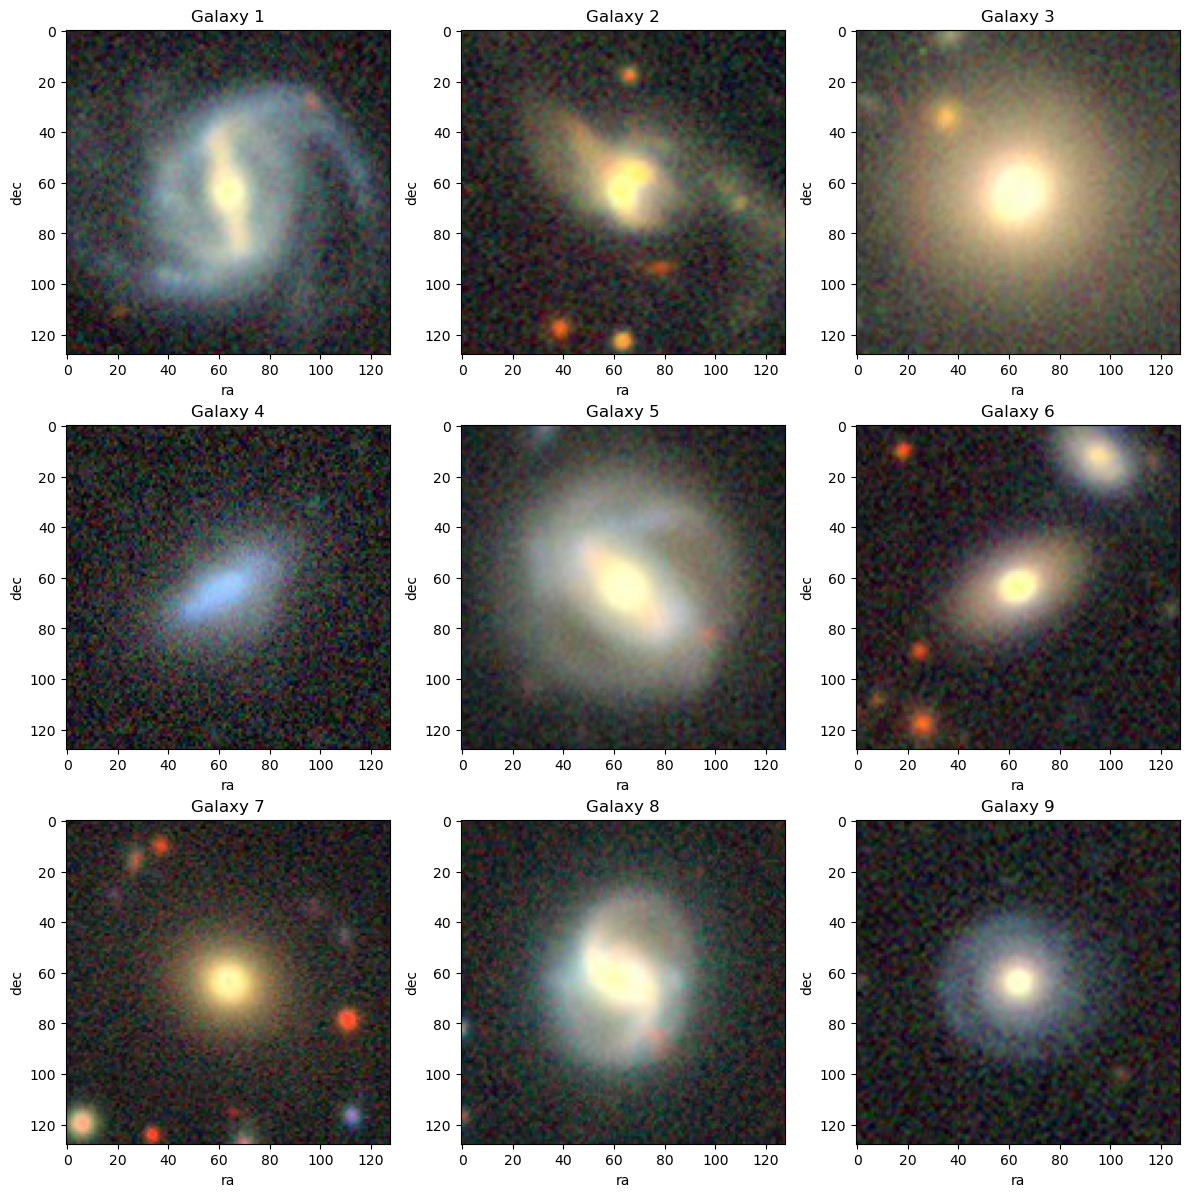

In [11]:
indices = np.random.choice(X_train.shape[0], 9)
Sample = X_train[indices]
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Sample[i])
    plt.title(f'Galaxy {i + 1}')
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.tight_layout()
plt.show()

In [12]:
from torchmetrics import StructuralSimilarityIndexMeasure
def MSLE_Loss(y_pred, y_true):
    eps = torch.FloatTensor([1e-6]).to(device)
    mse = F.mse_loss(torch.log1p(torch.maximum(y_pred, eps)), torch.log1p(torch.maximum(y_true, eps)), reduction = 'mean')
    ssim = StructuralSimilarityIndexMeasure(data_range = 1.0, reduction = 'mean')(y_pred, y_true)
    return mse + ssim

In [13]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoise, self).__init__()
        self.stddev = stddev
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

In [14]:
class Encoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Encoder, self).__init__()

        self.GaussianNoise = GaussianNoise(0.1)
        #self.BatchNorm0 = nn.BatchNorm2d(3)
        self.conv1a = nn.Conv2d(3, 8, 3, padding = 1) # 64 x 64
        self.conv1b = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv1c = nn.Conv2d(3, 16, 1)

        self.MaxPool1 = nn.MaxPool2d(2, 2)
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.LeakyReLU()

        self.conv2a = nn.Conv2d(16, 32, 3, padding = 1) # 32 x 32
        self.conv2b = nn.Conv2d(32, 64, 3, padding = 1) # 16 x 16
        self.conv2c = nn.Conv2d(16, 64, 1)

        self.MaxPool2 = nn.MaxPool2d(2, 2)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(dropout_rate)
        self.activation_2 = nn.LeakyReLU()

        self.conv3a = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16
        self.conv3b = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3c = nn.Conv2d(64, 128, 1)

        self.MaxPool3 = nn.MaxPool2d(2, 2)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout(dropout_rate)
        self.activation_3 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(dropout_rate)
        self.activation_4 = nn.LeakyReLU()


    def forward(self, x):
        x = self.GaussianNoise(x)
        x_skip = x
        x = self.BatchNorm1(self.activation(self.conv1b(self.conv1a(x_skip))))
        x_skip = self.conv1c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout(x)
        x = self.MaxPool1(x)

        x_skip = x
        x = self.BatchNorm2(self.activation_2(self.conv2b(self.conv2a(x))))
        x_skip = self.conv2c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_2(x)
        x = self.MaxPool2(x)

        x_skip = x
        x = self.BatchNorm3(self.activation_3(self.conv3b(self.conv3a(x))))
        x_skip = self.conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_3(self.MaxPool3(x))

        x_skip = x
        x = self.BatchNorm4(self.activation_4(self.conv4b(self.conv4a(x))))
        x_skip = self.conv4c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_4(x)
        x = self.MaxPool4(x)

        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [15]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
    
        self.TransConv1a = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding= 1, output_padding= 1) # 4 x 4
        self.Conv1b = nn.Conv2d(128, 64, 3, stride = 1, padding = 1) 
        self.Conv1c = nn.Conv2d(128, 64, 1, stride = 1, padding = 0)
        self.Conv1d = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(64)
        #self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.LeakyReLU()

        self.TransConv2a = nn.ConvTranspose2d(64, 32, 2, stride = 2, padding= 0, output_padding= 0) # 8 x 8
        self.Conv2b = nn.Conv2d(32, 16, 3, stride = 1, padding = 1) 
        self.Conv2c = nn.Conv2d(32, 16, 1, stride = 1, padding = 0)
        self.Conv2d = nn.Conv2d(16, 16, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.LeakyReLU()

        self.TransConv3a = nn.ConvTranspose2d(16, 8, 3, stride = 2, padding= 1, output_padding= 1) # 16 x 16
        self.Conv3b = nn.Conv2d(8, 4, 3, stride = 1, padding = 1)
        self.Conv3c = nn.Conv2d(8, 4, 1, stride = 1, padding = 0) 
        self.Conv3d = nn.Conv2d(4, 4, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(4)
        #self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.LeakyReLU()

        self.TransConv4a = nn.ConvTranspose2d(4, 3, 2, stride = 2, padding= 0, output_padding= 0) # 32 x 32
        self.Conv4b = nn.Conv2d(3, 3, 3, stride = 1, padding = 1) 
        self.Conv4c = nn.Conv2d(3, 3, 1, stride = 1, padding = 0)
        self.Conv4d = nn.Conv2d(3, 3, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        #self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.LeakyReLU()

    
    def forward(self, x):
        # x 4 x 4
        x_skip = self.TransConv1a(x)
        x = self.activation1(self.Batchnorm1(self.Conv1b(x_skip)))
        x_skip = self.Conv1c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv1d(x)
        #x = self.dropout1(x)

        x_skip = self.TransConv2a(x)
        x = self.activation2(self.Batchnorm2(self.Conv2b(x_skip)))
        x_skip = self.Conv2c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv2d(x)
        # x = self.dropout2(x)

        x_skip = self.TransConv3a(x)
        x = self.activation3(self.Batchnorm3(self.Conv3b(x_skip)))
        x_skip = self.Conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv3d(x)
        # x = self.dropout3(x)

        x_skip = self.TransConv4a(x)
        x = self.activation4(self.Batchnorm4(self.Conv4b(x_skip)))
        x_skip = self.Conv4c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv4d(x)
        #x = self.dropout4(x)
        
        x = F.sigmoid(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [16]:
class Convolutional_AE(pL.LightningModule):
    def __init__(self, learning_rate, dropout_rate, weight_decay):
        super(Convolutional_AE, self).__init__()
        
        self.encoder = Encoder(dropout_rate)
        self.decoder = Decoder(dropout_rate)
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def latent_space(self, x):
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Training_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Validation_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience = 10, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        ReconstructedImage = self.forward(x)
        return ReconstructedImage
    
    def latent_space_step(self, batch, batch_idx):
        x, y = batch
        LatentSpace = self.latent_space(x)
        return LatentSpace
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Test_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

In [18]:
X_Train_Tensor = torch.tensor(X_train).float().permute(0, 3, 1, 2).to(device)
Y_Train_Tensor = torch.tensor(X_train).float().permute(0, 3, 1, 2).to(device)
X_Valid_Tensor = torch.tensor(X_Valid).float().permute(0, 3, 1, 2).to(device)
Y_Valid_Tensor = torch.tensor(X_Valid).float().permute(0, 3, 1, 2).to(device)
X_Train_Dataloder = DataLoader(list(zip(X_Train_Tensor, X_Train_Tensor)), batch_size = 64, shuffle = True)
X_Valid_Dataloder = DataLoader(list(zip(X_Valid_Tensor, X_Valid_Tensor)), batch_size = 64, shuffle = False)
X_Train_Dataloder

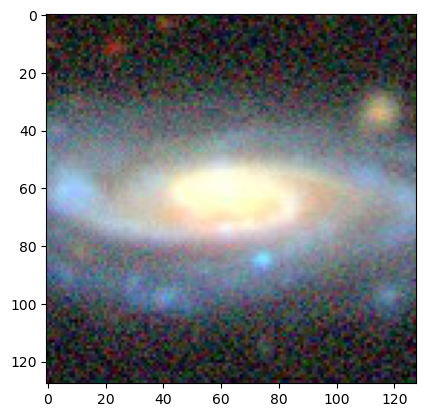

In [19]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem)
    break

(array([4114., 8430., 8018., 5784., 6282., 5534., 4221., 3208., 1755.,
        1806.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

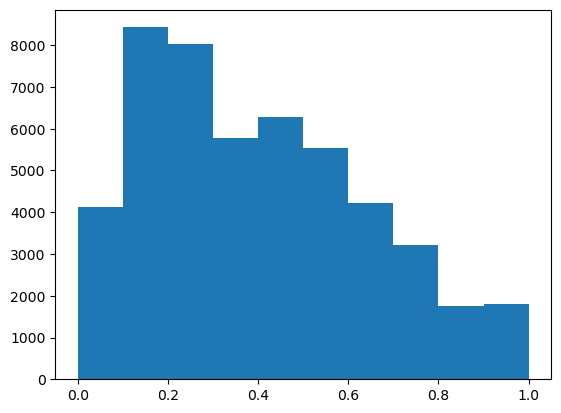

In [20]:
plt.hist(element.detach().cpu().numpy().reshape(-1,))

In [21]:
AE_Model = Convolutional_AE(learning_rate = 2e-3, dropout_rate= 0.15, weight_decay = 1e-5)
AE_Model = AE_Model.to(device)

In [23]:
torchsummary.summary(AE_Model, (3, 128, 128), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1          [-1, 3, 128, 128]               0
       BatchNorm2d-2          [-1, 3, 128, 128]               6
            Conv2d-3          [-1, 8, 128, 128]             224
            Conv2d-4         [-1, 16, 128, 128]           1,168
         LeakyReLU-5         [-1, 16, 128, 128]               0
       BatchNorm2d-6         [-1, 16, 128, 128]              32
            Conv2d-7         [-1, 16, 128, 128]              64
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,640
           Conv2d-10           [-1, 64, 64, 64]          18,496
        LeakyReLU-11           [-1, 64, 64, 64]               0
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]           1,088
        MaxPool2d-14           [-1, 64,

In [26]:
element = element.view(-1, 3, 128, 128)
element = element.to(device)
element.shape

torch.Size([1, 3, 128, 128])

In [27]:
AE_Model.predict_step((element, element), 1).shape

torch.Size([1, 3, 128, 128])

In [28]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 10, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss", save_top_k = 1, mode = "min", save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "Possion_AE")
Max_Epochs = 50

name = "CAE"
CHECKPOINT_PATH = './models/'

Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

Trainer.fit(AE_Model, X_Train_Dataloder, X_Valid_Dataloder)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.2 M 
1 | decoder | Decoder | 431 K 
------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [29]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.004491494502872229    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.004491494502872229}]

In [30]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.005065723787993193    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.005065723787993193}]

In [31]:
element = element.to(device)
AE_Model.to(device)

Convolutional_AE(
  (encoder): Encoder(
    (GaussianNoise): GaussianNoise()
    (BatchNorm0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1a): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1b): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1c): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (BatchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.15, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01)
    (conv2a): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2b): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2c): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Ba

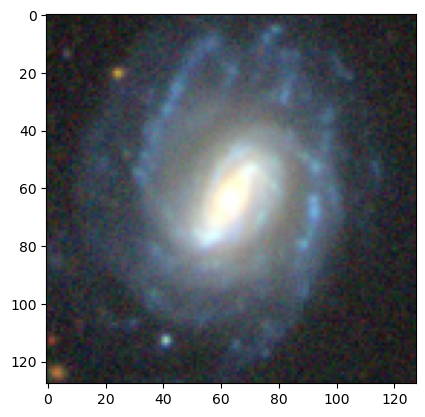

In [117]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem)
    break

In [118]:
element = element.view(-1, 3, 128, 128).to(device)
Trial = AE_Model.predict_step((element, element), 1)
Trial.shape

torch.Size([1, 3, 128, 128])

In [119]:
element

tensor([[[[0.1255, 0.0902, 0.1333,  ..., 0.1529, 0.1137, 0.1490],
          [0.1020, 0.0745, 0.1294,  ..., 0.1412, 0.2196, 0.1608],
          [0.1451, 0.1137, 0.2235,  ..., 0.1686, 0.1176, 0.1098],
          ...,
          [0.2706, 0.3176, 0.5020,  ..., 0.0706, 0.1373, 0.1098],
          [0.1608, 0.1961, 0.3529,  ..., 0.0902, 0.2118, 0.1216],
          [0.1412, 0.2196, 0.2392,  ..., 0.1412, 0.1804, 0.2510]],

         [[0.1451, 0.1529, 0.0784,  ..., 0.1059, 0.1059, 0.0745],
          [0.1020, 0.1333, 0.0980,  ..., 0.1529, 0.0863, 0.1176],
          [0.1020, 0.1137, 0.1216,  ..., 0.1608, 0.0745, 0.1059],
          ...,
          [0.2392, 0.2824, 0.3608,  ..., 0.1137, 0.1608, 0.1490],
          [0.2588, 0.3608, 0.2431,  ..., 0.1373, 0.1216, 0.1608],
          [0.1608, 0.2667, 0.2157,  ..., 0.1490, 0.0745, 0.1020]],

         [[0.1098, 0.0588, 0.1255,  ..., 0.0824, 0.1059, 0.1412],
          [0.1961, 0.1490, 0.1020,  ..., 0.1294, 0.1059, 0.0980],
          [0.0863, 0.0824, 0.1529,  ..., 0

In [120]:
Trial

tensor([[[[0.2348, 0.1350, 0.1574,  ..., 0.1345, 0.1653, 0.1597],
          [0.1583, 0.1083, 0.0910,  ..., 0.1178, 0.1080, 0.1361],
          [0.1579, 0.1063, 0.0994,  ..., 0.1330, 0.1105, 0.1373],
          ...,
          [0.2185, 0.1622, 0.1691,  ..., 0.1222, 0.1083, 0.1322],
          [0.2224, 0.1707, 0.1575,  ..., 0.1158, 0.0958, 0.1329],
          [0.2464, 0.2211, 0.1912,  ..., 0.1897, 0.1255, 0.2371]],

         [[0.2324, 0.1539, 0.1640,  ..., 0.1533, 0.1696, 0.1923],
          [0.1604, 0.0982, 0.0931,  ..., 0.0998, 0.0988, 0.1299],
          [0.1654, 0.0988, 0.0987,  ..., 0.1160, 0.1070, 0.1307],
          ...,
          [0.2146, 0.1627, 0.1630,  ..., 0.1204, 0.1093, 0.1288],
          [0.2143, 0.1637, 0.1617,  ..., 0.1131, 0.1042, 0.1288],
          [0.2692, 0.2173, 0.1986,  ..., 0.1572, 0.1384, 0.1812]],

         [[0.1851, 0.1353, 0.1187,  ..., 0.1313, 0.1249, 0.1791],
          [0.1453, 0.0901, 0.0884,  ..., 0.0962, 0.0915, 0.1188],
          [0.1489, 0.0866, 0.0947,  ..., 0

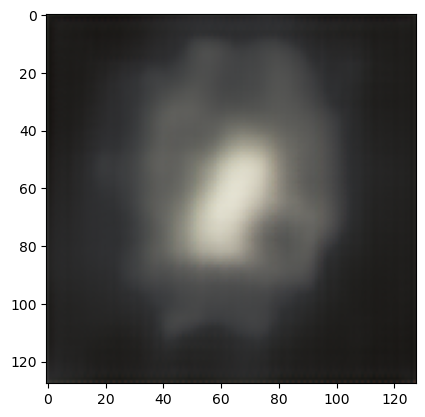

In [121]:
Trialler = Trial.permute(0,2,3,1).detach().cpu().numpy()
Trialler = Trialler[0]
plt.imshow(Trialler)